## 1. Imports

In [196]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import datetime
from prettytable import PrettyTable

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, make_scorer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import VotingClassifier, HistGradientBoostingClassifier

import shap
import optuna
from optuna import Trial
from optuna import create_study
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from utils.eda import summary

## 2. Notebook Settings

In [177]:
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.2f}'.format

## 3. Config

In [178]:
class CFG:
    use_org = True
    use_pseudo = False

## 3. Data Load

In [179]:
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')
submission_df = pd.read_csv('sample_submission.csv')

## 4. Add Original Data

In [180]:
if CFG.use_org:
    train_df.drop(columns=["id"],inplace=True)

    original = pd.read_csv('original_train.csv')
    original.drop(columns=['RowNumber'],inplace=True)

    train_df = pd.concat([train_df, original], axis=0)
    train_df.dropna(inplace=True)

## 5. EDA

In [181]:
def summary(df: pd.DataFrame) -> pd.DataFrame:
    '''Returns a summary table with stats, missing values etc.'''
    print(f'data shape: {df.shape}')
    duplicates = df[df.duplicated()]
    print(f"Number of duplicates found and removed: {len(duplicates)}")
    df = df.drop_duplicates()
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df) * 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['average'] = desc['mean'].values
    summ['standard_deviation'] = desc['std'].values
    
    return summ

In [182]:
summary_df = summary(test_df)
summary_df

data shape: (110023, 13)
Number of duplicates found and removed: 0


,data type,#missing,%missing,#unique,min,max,average,standard_deviation
id,int64,0,0.00,110023,"165,034.00","275,056.00","220,045.00","31,761.05"
CustomerId,int64,0,0.00,19698,"15,565,701.00","15,815,690.00","15,692,096.61","71,684.99"
Surname,object,0,0.00,2708,NaN,NaN,NaN,NaN
CreditScore,int64,0,0.00,454,350.00,850.00,656.53,80.32
Geography,object,0,0.00,3,NaN,NaN,NaN,NaN
Gender,object,0,0.00,2,NaN,NaN,NaN,NaN
Age,float64,0,0.00,74,18.00,92.00,38.12,8.86
Tenure,int64,0,0.00,11,0.00,10.00,5.00,2.81
Balance,float64,0,0.00,22513,0.00,"250,898.09","55,333.61","62,788.52"
NumOfProducts,int64,0,0.00,4,1.00,4.00,1.55,0.54


In [183]:
summary_df = summary(train_df)
summary_df

data shape: (175032, 13)
Number of duplicates found and removed: 2


,data type,#missing,%missing,#unique,min,max,average,standard_deviation
CustomerId,int64,0,0.00,23421,"15,565,701.00","15,815,690.00","15,691,944.51","71,428.44"
Surname,object,0,0.00,2932,NaN,NaN,NaN,NaN
CreditScore,int64,0,0.00,460,350.00,850.00,656.11,81.15
Geography,object,0,0.00,3,NaN,NaN,NaN,NaN
Gender,object,0,0.00,2,NaN,NaN,NaN,NaN
Age,float64,0,0.00,73,18.00,92.00,38.17,8.97
Tenure,int64,0,0.00,11,0.00,10.00,5.02,2.81
Balance,float64,0,0.00,30239,0.00,"250,898.09","56,677.30","62,982.32"
NumOfProducts,int64,0,0.00,4,1.00,4.00,1.55,0.55
HasCrCard,float64,0,0.00,2,0.00,1.00,0.75,0.43


### 5.1. Numerical/Categorical Data Split

In [184]:
cat_cols = [column for column in train_df.columns if train_df[column].dtype == 'object']
num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()

num_cols.remove('Exited')
num_cols.remove('CustomerId')
cat_cols.remove('Surname')

num_cols.remove('IsActiveMember')
cat_cols.append('IsActiveMember')

num_cols.remove('Tenure')
cat_cols.append('Tenure')

num_cols.remove('NumOfProducts')
cat_cols.append('NumOfProducts')

num_cols.remove('HasCrCard')
cat_cols.append('HasCrCard')

target_col = 'Exited'

train_df['HasCrCard'].astype('category')
train_df['IsActiveMember'].astype('category');

In [185]:
print(f'Category Columns: {cat_cols}')
print(f'Numerical Columns: {num_cols}')
print(f'Target Column: {target_col}')

Category Columns: ['Geography', 'Gender', 'IsActiveMember', 'Tenure', 'NumOfProducts', 'HasCrCard']
Numerical Columns: ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
Target Column: Exited


### 5.2 Target Distribution
Source: https://www.kaggle.com/code/arunklenin/ps4e1-advanced-feature-engineering-ensemble

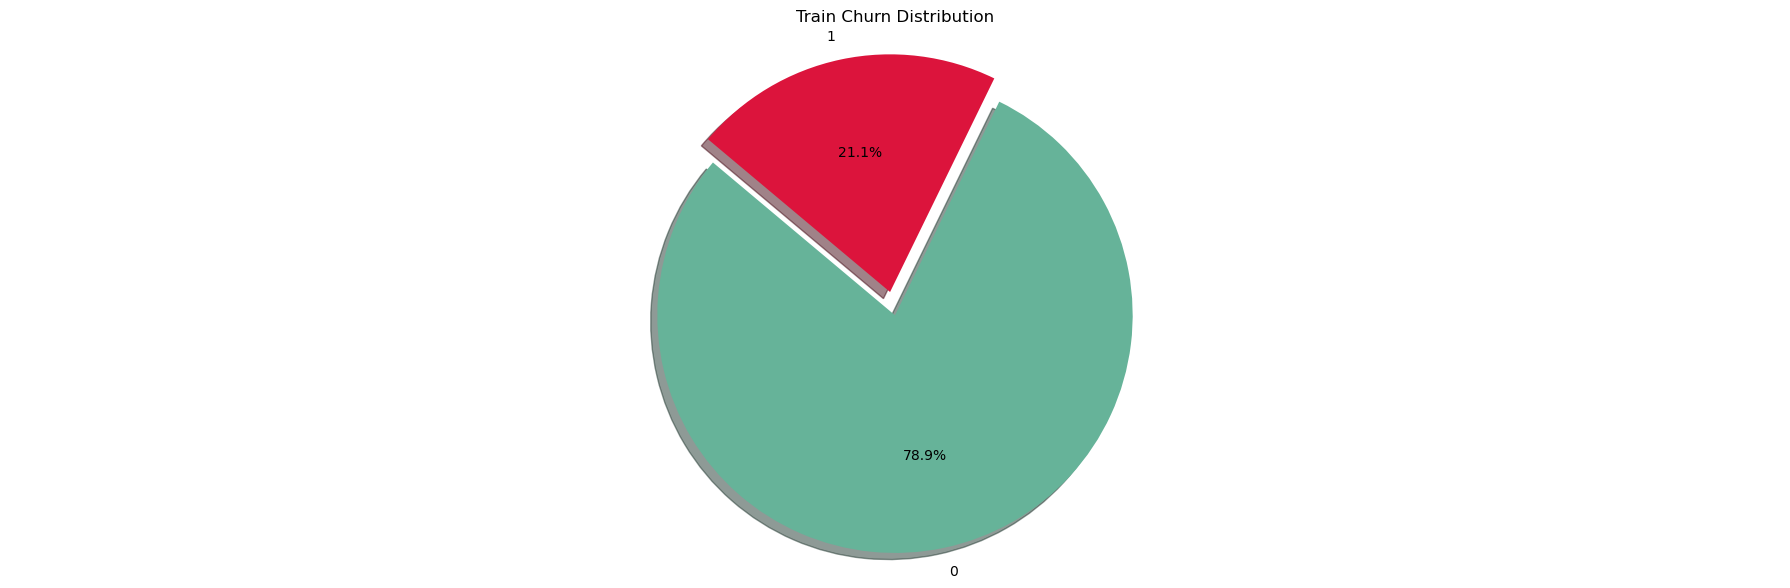

In [186]:
def plot_pie_chart(data, title, ax):
    data_counts = data[target_col].value_counts()
    labels = data_counts.index
    sizes = data_counts.values
    colors = [ (0.4, 0.7, 0.6), 'crimson']  
    explode = (0.1, 0)  

    ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    ax.axis('equal') 
    ax.set_title(title)

fig, axes = plt.subplots(1, 1, figsize=(18, 6))  # Create three subplots in a row

plot_pie_chart(train_df, "Train Churn Distribution", axes)

plt.tight_layout()
plt.show()

### 5.3 Numerical Data Analysis 
Source: https://www.kaggle.com/code/arunklenin/ps4e1-advanced-feature-engineering-ensemble

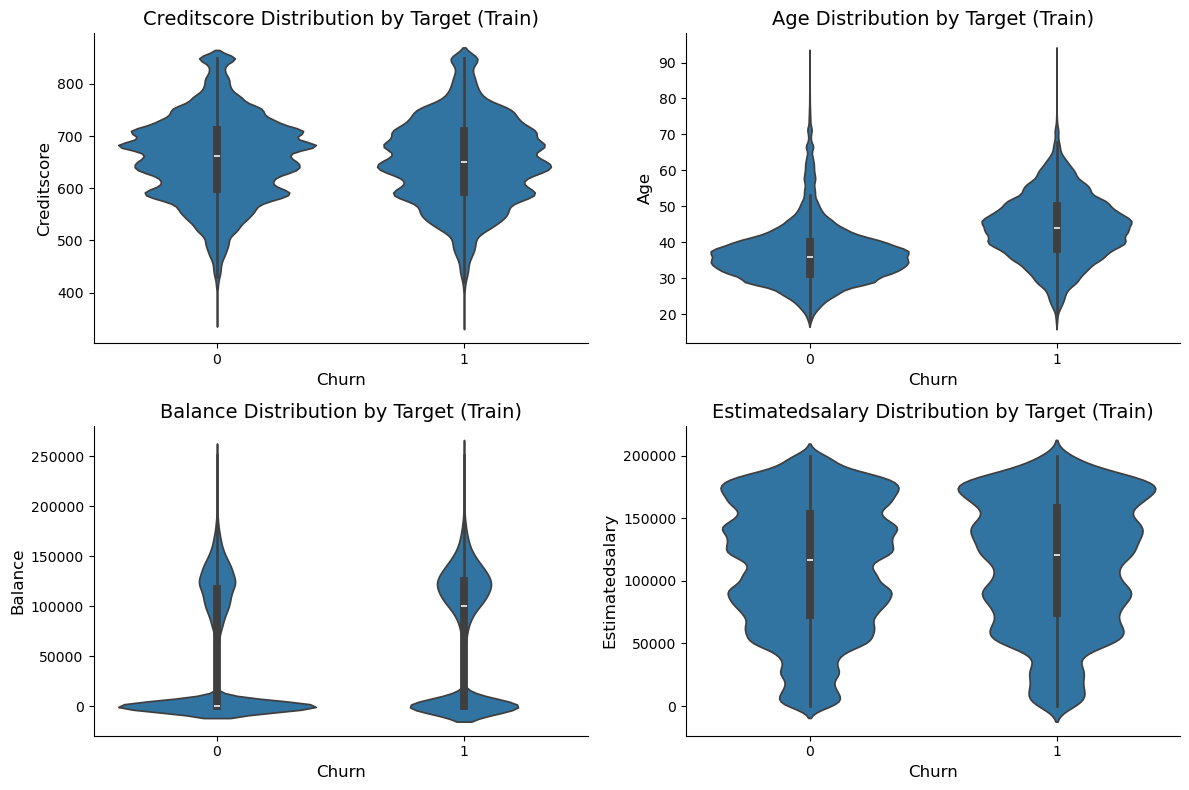

In [187]:
n_rows = len(num_cols)
n_cols = 2
fig, axs = plt.subplots(n_rows // n_cols, n_cols, figsize=(12, 4 * (n_rows // n_cols)))
sns.set_palette("Set3")

for i, col in enumerate(num_cols):
    row_idx = i // n_cols
    col_idx = i % n_cols

    sns.violinplot(x=target_col, y=col, data=train_df, ax=axs[row_idx, col_idx])
    axs[row_idx, col_idx].set_title(f'{col.title()} Distribution by Target (Train)', fontsize=14)
    axs[row_idx, col_idx].set_xlabel('Churn', fontsize=12)
    axs[row_idx, col_idx].set_ylabel(col.title(), fontsize=12)
    sns.despine()

fig.tight_layout()

plt.show()

### 5.4 EDA Categorical Data Analysis
Source: https://www.kaggle.com/code/arunklenin/ps4e1-advanced-feature-engineering-ensemble

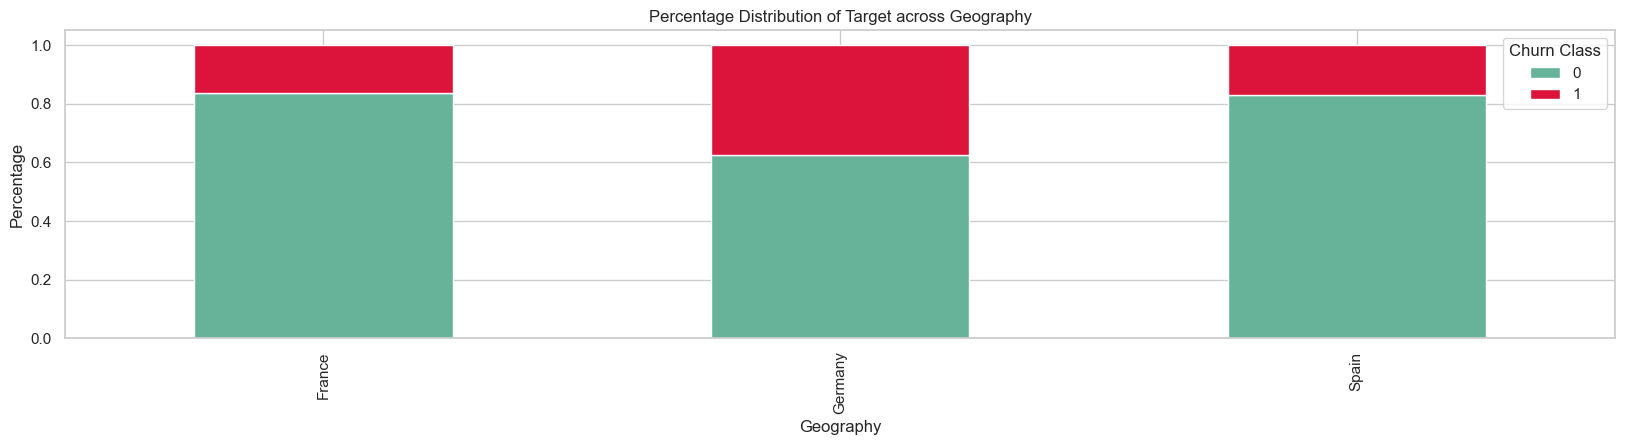

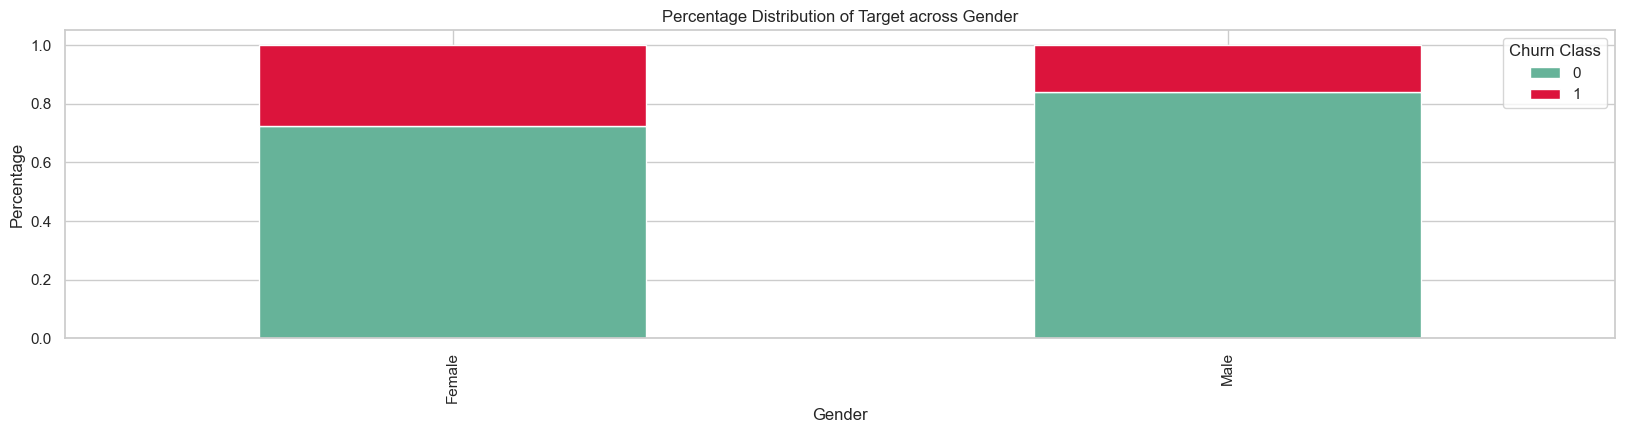

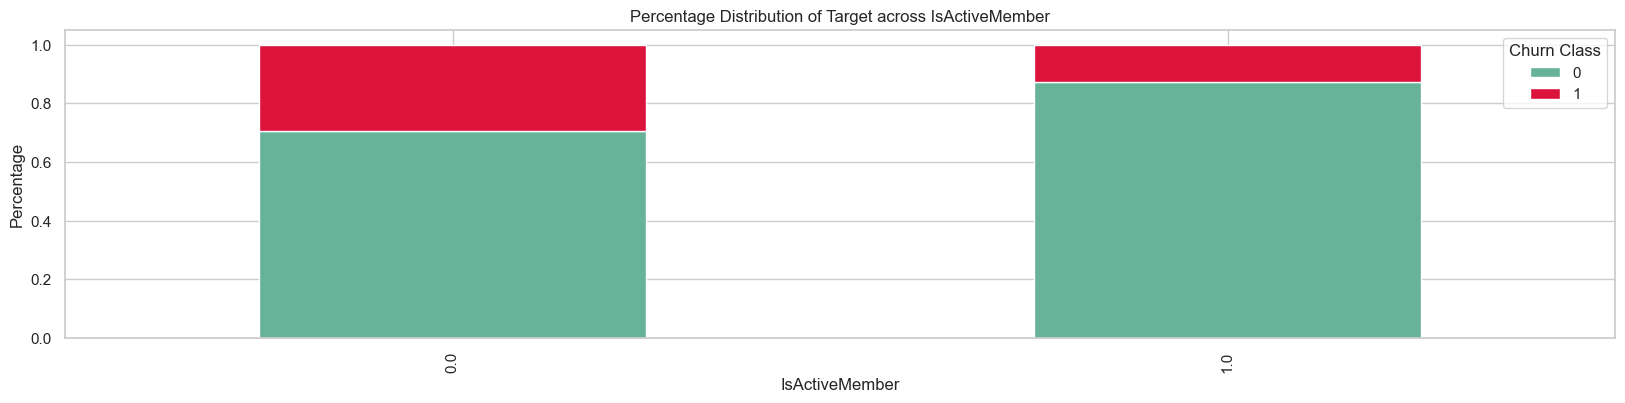

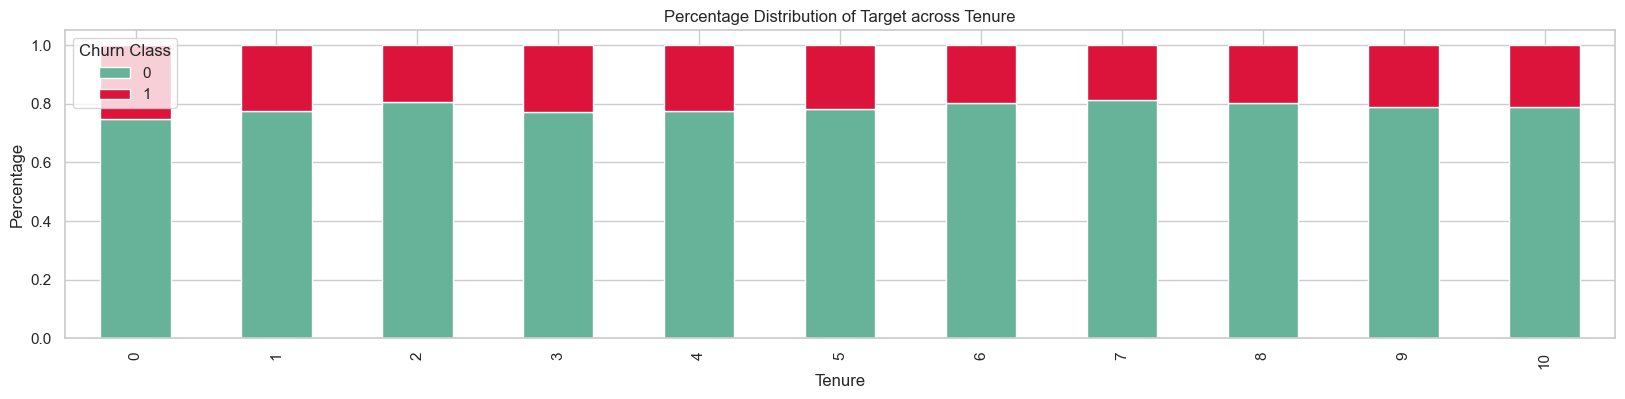

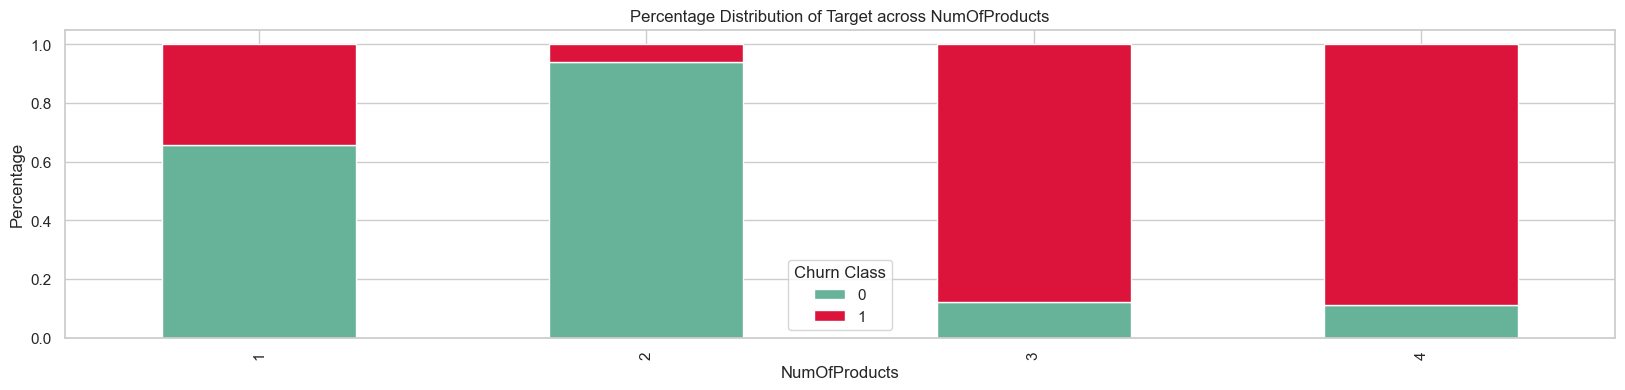

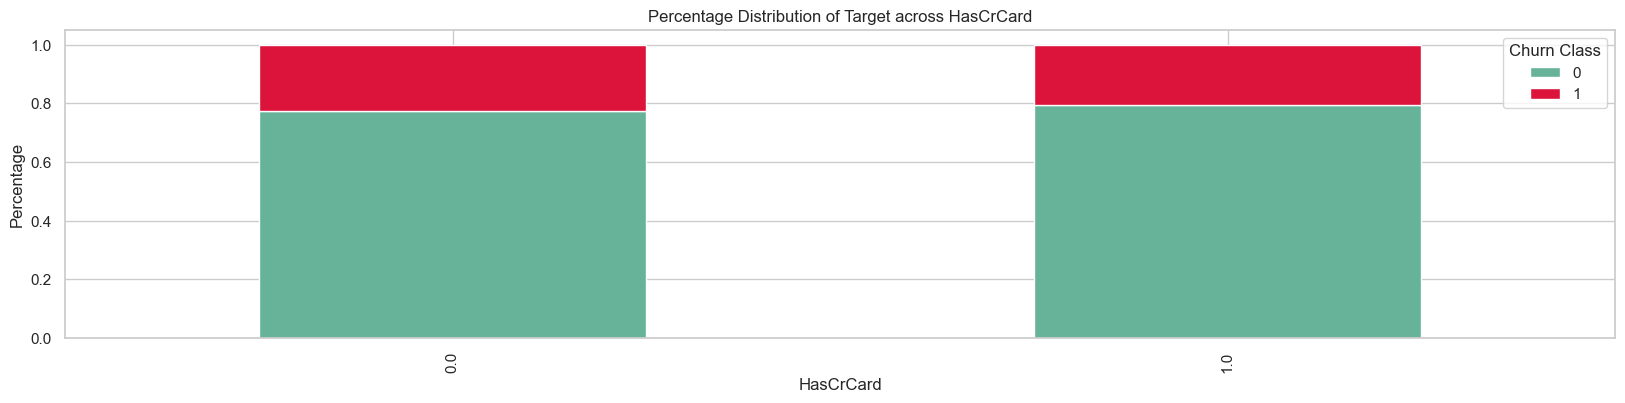

In [188]:
custom_palette =(0.4, 0.7, 0.6), 'crimson'
for col in cat_cols:
    contingency_table = pd.crosstab(train_df[col], train_df[target_col], normalize='index')
    sns.set(style="whitegrid")
    contingency_table.plot(kind="bar", stacked=True, color=custom_palette,figsize=(20, 4))
    plt.title(f"Percentage Distribution of Target across {col}")
    plt.xlabel(col)
    plt.ylabel("Percentage")
    plt.legend(title="Churn Class")
    plt.show()

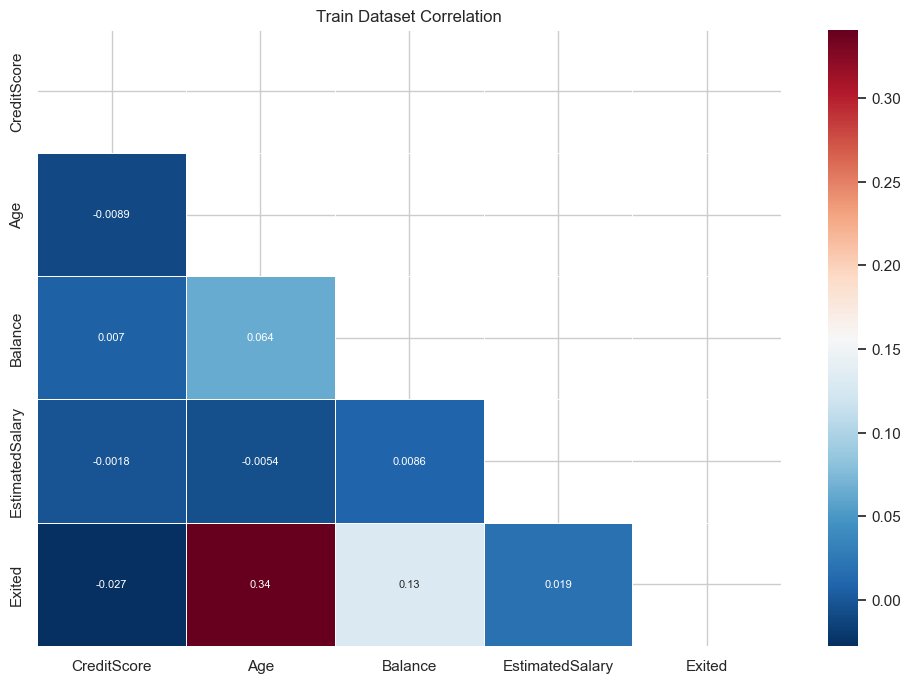

In [337]:
def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str='Train correlation') -> None:

    corr = df.corr()
    fig, axes = plt.subplots(figsize=(12, 8))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap='RdBu_r', annot=True,annot_kws={"size": 8})
    plt.title(title_name)
    plt.show()


plot_correlation_heatmap(train_df[num_cols+[target_col]], 'Train Dataset Correlation')

## 6. Feature Engineering
### 6.1 Arithmetical Operations betweeen columns

In [9]:
class ArithmeticFeatureCombiner(BaseEstimator, TransformerMixin):
    def __init__(self, num_cols):
        self.num_cols = num_cols
        self.new_num_cols = []

    def fit(self, X, y=None):
        # No fitting necessary for this transformer
        return self

    def transform(self, X):
        # Perform the arithmetic operations without creating redundant features
        for i, col1 in enumerate(self.num_cols):
            for col2 in self.num_cols[i+1:]:  # Start from i+1 to avoid redundancy
                X[f'{col1}+{col2}'] = X[col1] + X[col2]
                X[f'{col1}*{col2}'] = X[col1] * X[col2]
                self.new_num_cols.extend([f'{col1}+{col2}', f'{col1}*{col2}'])
        return X

    def get_feature_names_out(self):
        # Return the new column names after transformation
        return self.num_cols + self.new_num_cols

arithmetic_combiner = ArithmeticFeatureCombiner(num_cols)

### 6.2 Binning

In [33]:
class Binning(BaseEstimator, TransformerMixin):
    def __init__(self, col, n_bins):
        self.n_bins = n_bins
        self.col = col
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        transformed = pd.qcut(X[self.col], self.n_bins, labels=False, duplicates='drop')
        transformed[transformed.isna()] = 0
        transformed_series = pd.Series(transformed, 
                                       name=f'QCut{self.n_bins}{self.col}',
                                       index=X.index)
        X_copy = X.copy()
        return pd.concat([X_copy, transformed_series], axis=1)
    
age_binner = Binning('Age', 5)
balance_binner = Binning('Balance',5)
salary_binner = Binning('EstimatedSalary',5)
credit_score_binner = Binning('CreditScore',5)

### 6.3 Aggregations

In [121]:
class GroupByMergeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, group_col, agg_col, agg_func):
        self.group_col = group_col
        self.agg_col = agg_col
        self.agg_func = agg_func

    def fit(self, X, y=None):
        # Create the aggregated DataFrame
        self.agg_df_ = X.groupby(by=self.group_col).agg({self.agg_col: self.agg_func}).reset_index().rename(columns={self.agg_col: f'{self.agg_col}_agg'})
        return self

    def transform(self, X):
        # Merge the original DataFrame with the aggregated DataFrame
        merged = pd.merge(X, self.agg_df_, on=self.group_col, how='left')
        merged[f'{self.agg_col}_agg'] = merged[f'{self.agg_col}_agg'].fillna(0)
        return merged
    
agg_balance_sum = GroupByMergeTransformer(group_col='CustomerId', agg_col='Balance', agg_func='sum')

### 6.4 Zero Detection

In [12]:
class ZeroTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
        self.new_column_name = column+'_is_zero'

    def fit(self, X, y=None):
        # No fitting necessary for this transformer
        return self

    def transform(self, X):
        # Create a new column with the transformed values
        X[self.new_column_name] = X[self.column].apply(lambda x: 1 if x == 0 else 0)
        return X
    
# Create an instance of your custom transformer
balance_zero_transformer = ZeroTransformer(column='Balance')

### 6.5 Clustering

In [13]:
class PCAClusteringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns, n_components, n_clusters):
        self.columns = columns
        self.n_components = n_components
        self.n_clusters = n_clusters
        self.pca = PCA(n_components=self.n_components)
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)

    def fit(self, X, y=None):
        X_subset = X[self.columns]
        self.pca.fit(X_subset)
        X_pca = self.pca.transform(X_subset)
        self.kmeans.fit(X_pca)
        return self

    def transform(self, X):
        X_subset = X[self.columns]
        X_pca = self.pca.transform(X_subset)

        # Shift PCA components to be non-negative
        min_values = np.min(X_pca, axis=0)
        shift_values = np.abs(min_values) * (min_values < 0)
        X_pca += shift_values

        clusters = self.kmeans.predict(X_pca)
        X_transformed = X.copy()
        X_transformed['Cluster'] = clusters

        for i in range(self.n_components):
            X_transformed[f'PCA_{i}'] = X_pca[:, i]

        return X_transformed
    
pca_clustering_transformer = PCAClusteringTransformer(
    columns=["CustomerId","EstimatedSalary","Balance"], n_components=2, n_clusters=3)

### 6.6 Encoding

In [14]:
encoding = ColumnTransformer([
    ('encoder', OneHotEncoder(handle_unknown='ignore',sparse_output=False), cat_cols)
], remainder='passthrough').set_output(transform='pandas')

### 6.7 Scaling

In [15]:
class CustomMinMaxScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = MinMaxScaler()
        self.numerical_columns = []

    def fit(self, X, y=None):
        # Identify numerical columns
        self.numerical_columns = X.select_dtypes(include=[np.number]).columns
        self.scaler.fit(X[self.numerical_columns])
        return self

    def transform(self, X):
        # Apply MinMaxScaler only to numerical columns
        X_scaled = X.copy()
        X_scaled[self.numerical_columns] = self.scaler.transform(X[self.numerical_columns])
        return X_scaled


scaler = CustomMinMaxScaler()

## 7. Feature Selection

In [91]:
class CustomFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, k=20):
        self.k = k
        self.selector = SelectKBest(mutual_info_classif, k=self.k)

    def fit(self, X, y=None):
        # Ensure that X is a DataFrame
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input X must be a pandas DataFrame")
        
        # Fit the selector to the data
        self.selector.fit(X, y)
        return self

    def transform(self, X):
        # Transform the data and return a DataFrame
        X_transformed = self.selector.transform(X)
        selected_features = X.columns[self.selector.get_support()]
        return pd.DataFrame(X_transformed, columns=selected_features)
        

feature_selector = CustomFeatureSelector()

### 7.1 Correlation table 
https://www.kaggle.com/code/ashishkumarak/binary-classification-smoker-or-not-eda-xgboost

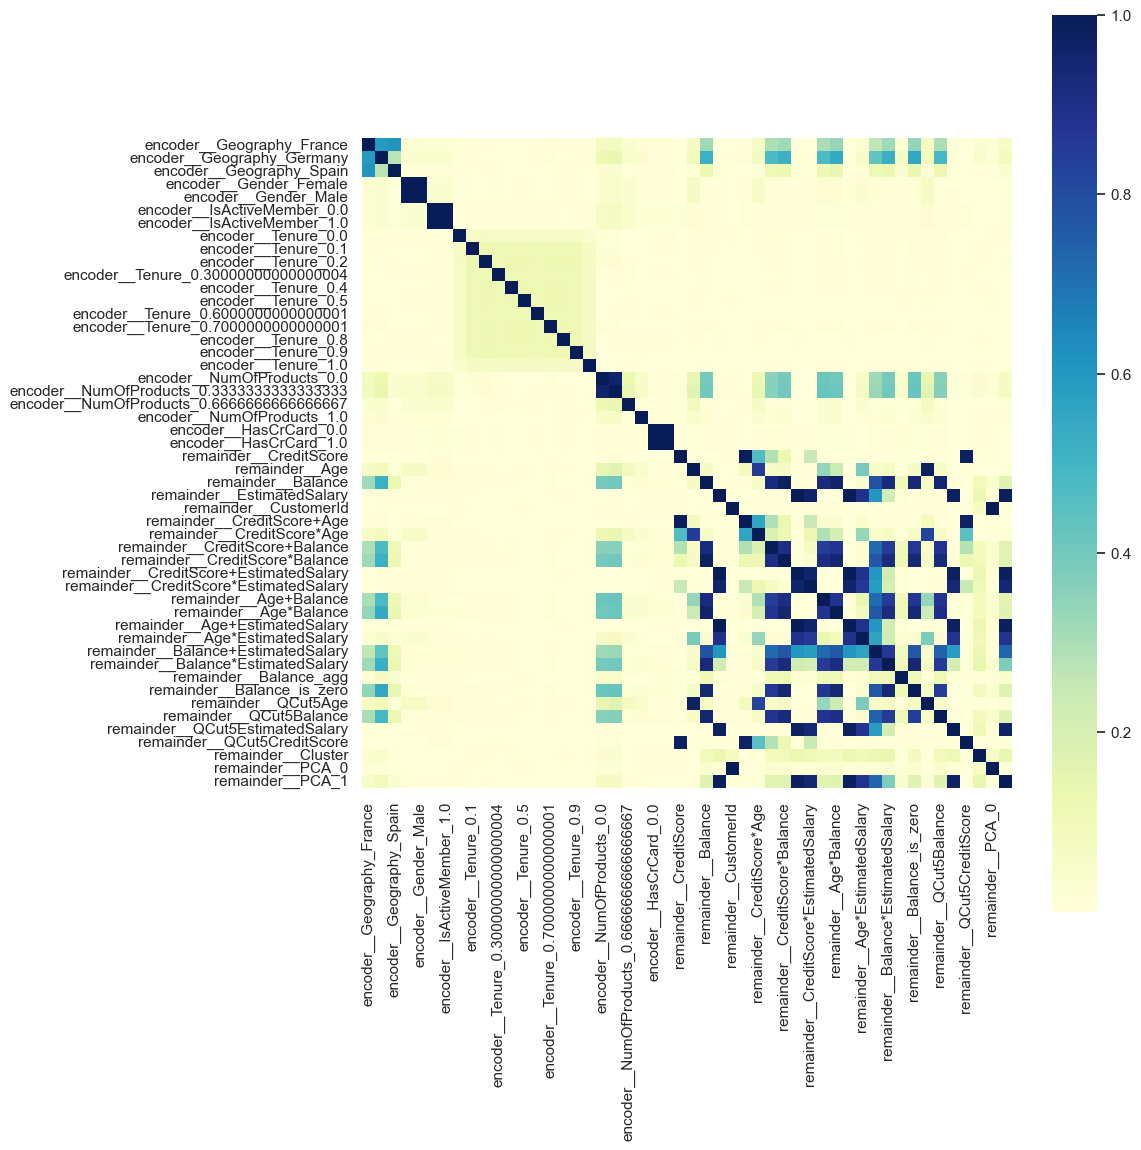

In [190]:
pipeline_all = Pipeline([
    ('arithmetic_combiner', arithmetic_combiner),
    ('agg_balance_sum', agg_balance_sum),
    ('balance_zero_transformer', balance_zero_transformer),
    ('age_binning', age_binner),
    ('balance_binner', balance_binner),
    ('salary_binner', salary_binner),
    ('credit_score_binner', credit_score_binner),
    ('scaler', scaler),
    ('pca_cluster', pca_clustering_transformer),
    ('encoder', encoding),
    ])

train_df_all = pipeline_all.fit_transform(train_df[cat_cols+num_cols+['CustomerId']], train_df['Exited'])

corr_matrix = train_df_all.corr(method = 'spearman').abs()

# Set font scale
sns.set(font_scale = 1)

# Set the figure size
f, ax = plt.subplots(figsize=(12, 12))

# Make heatmap
sns.heatmap(corr_matrix, cmap= 'YlGnBu', square=True, ax = ax)

# Tight layout
f.tight_layout()

# Save figure
f.savefig('correlation_matrix.png', dpi = 1080)

,encoder__Geography_France,encoder__Geography_Germany,encoder__Gender_Female,encoder__Gender_Male,encoder__IsActiveMember_0.0,encoder__IsActiveMember_1.0,encoder__NumOfProducts_0.0,encoder__NumOfProducts_0.3333333333333333,encoder__NumOfProducts_0.6666666666666667,encoder__HasCrCard_1.0,remainder__Age,remainder__Balance,remainder__CreditScore*Age,remainder__CreditScore+Balance,remainder__Age+Balance,remainder__Age*Balance,remainder__Age+EstimatedSalary,remainder__Age*EstimatedSalary,remainder__Balance_is_zero,remainder__QCut5Age
0,1.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,1.00,0.20,0.00,0.21,0.00,0.00,0.00,0.91,0.33,1.00,0.25
1,1.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.20,0.00,0.19,0.00,0.00,0.00,0.25,0.09,1.00,0.25
2,1.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,1.00,0.30,0.00,0.29,0.00,0.00,0.00,0.92,0.41,1.00,0.75
3,1.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00,0.00,1.00,0.22,0.59,0.18,0.59,0.59,0.35,0.42,0.16,0.00,0.25
4,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.20,0.00,0.23,0.00,0.00,0.00,0.08,0.03,1.00,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175027,1.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.24,0.00,0.26,0.00,0.00,0.00,0.21,0.08,1.00,0.50
175028,0.00,1.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,1.00,0.32,0.30,0.36,0.30,0.30,0.22,0.46,0.22,0.00,0.75
175029,0.00,1.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,1.00,0.32,0.30,0.36,0.30,0.30,0.22,0.46,0.22,0.00,0.75
175030,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.14,0.52,0.21,0.52,0.52,0.25,0.19,0.06,0.00,0.00


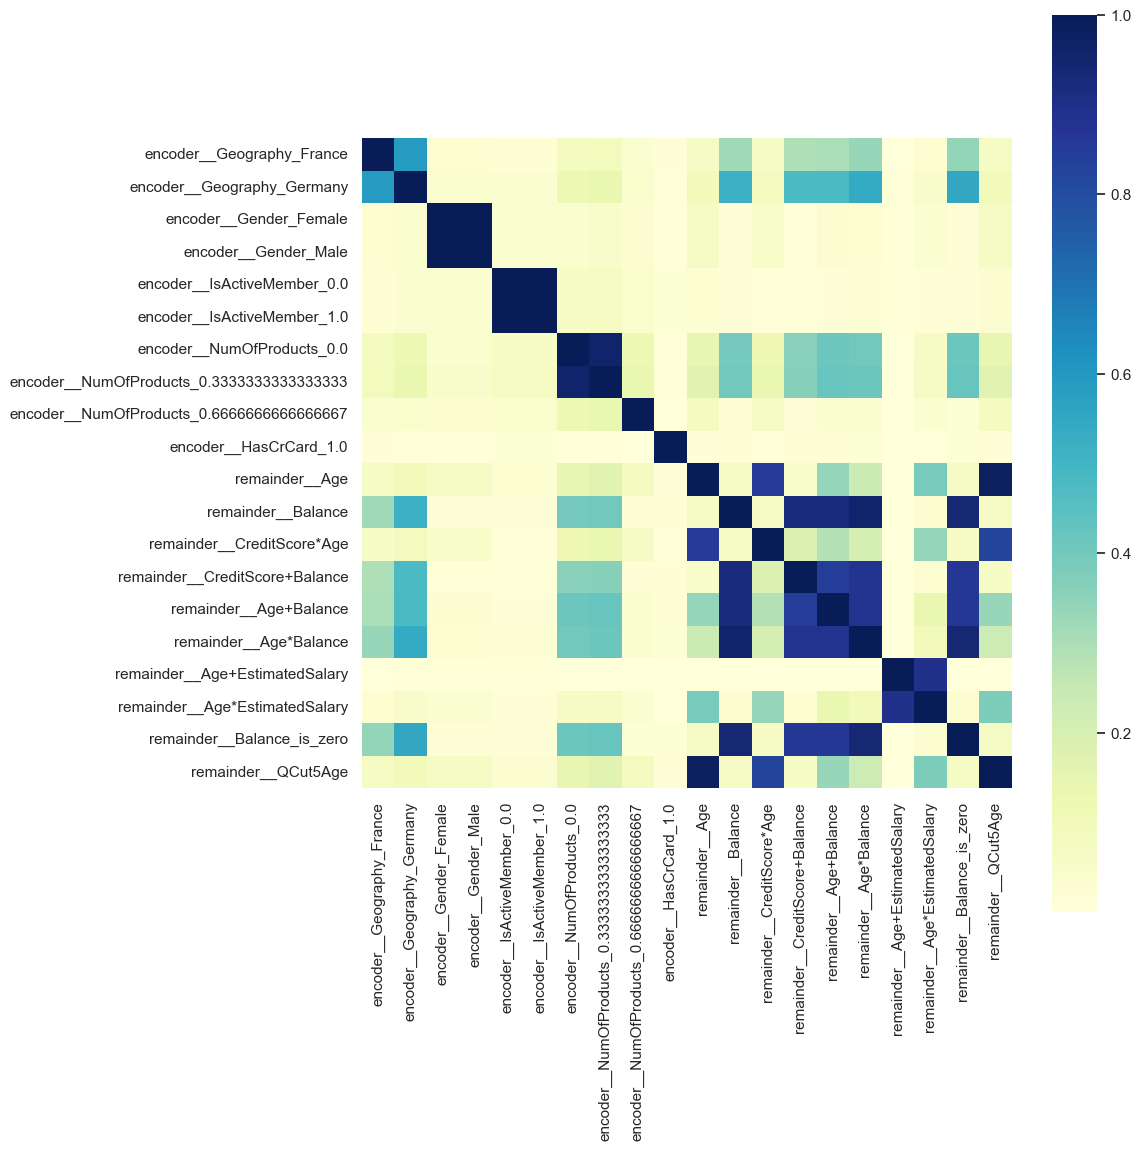

In [197]:
pipeline_all_sel = Pipeline([
    ('arithmetic_combiner', arithmetic_combiner),
    ('agg_balance_sum', agg_balance_sum),
    ('balance_zero_transformer', balance_zero_transformer),
    ('age_binning', age_binner),
    ('balance_binner', balance_binner),
    ('salary_binner', salary_binner),
    ('credit_score_binner', credit_score_binner),
    ('scaler', scaler),
    ('pca_cluster', pca_clustering_transformer),
    ('encoder', encoding),
    ('skb', feature_selector)
    ])

train_df_sel = pipeline_all_sel.fit_transform(train_df[cat_cols+num_cols+['CustomerId']], train_df['Exited'])

corr_matrix = train_df_sel.corr(method = 'spearman').abs()

# Set font scale
sns.set(font_scale = 1)

# Set the figure size
f, ax = plt.subplots(figsize=(12, 12))

# Make heatmap
sns.heatmap(corr_matrix, cmap= 'YlGnBu', square=True, ax = ax)

# Tight layout
f.tight_layout()

# Save figure
f.savefig('correlation_matrix.png', dpi = 1080)

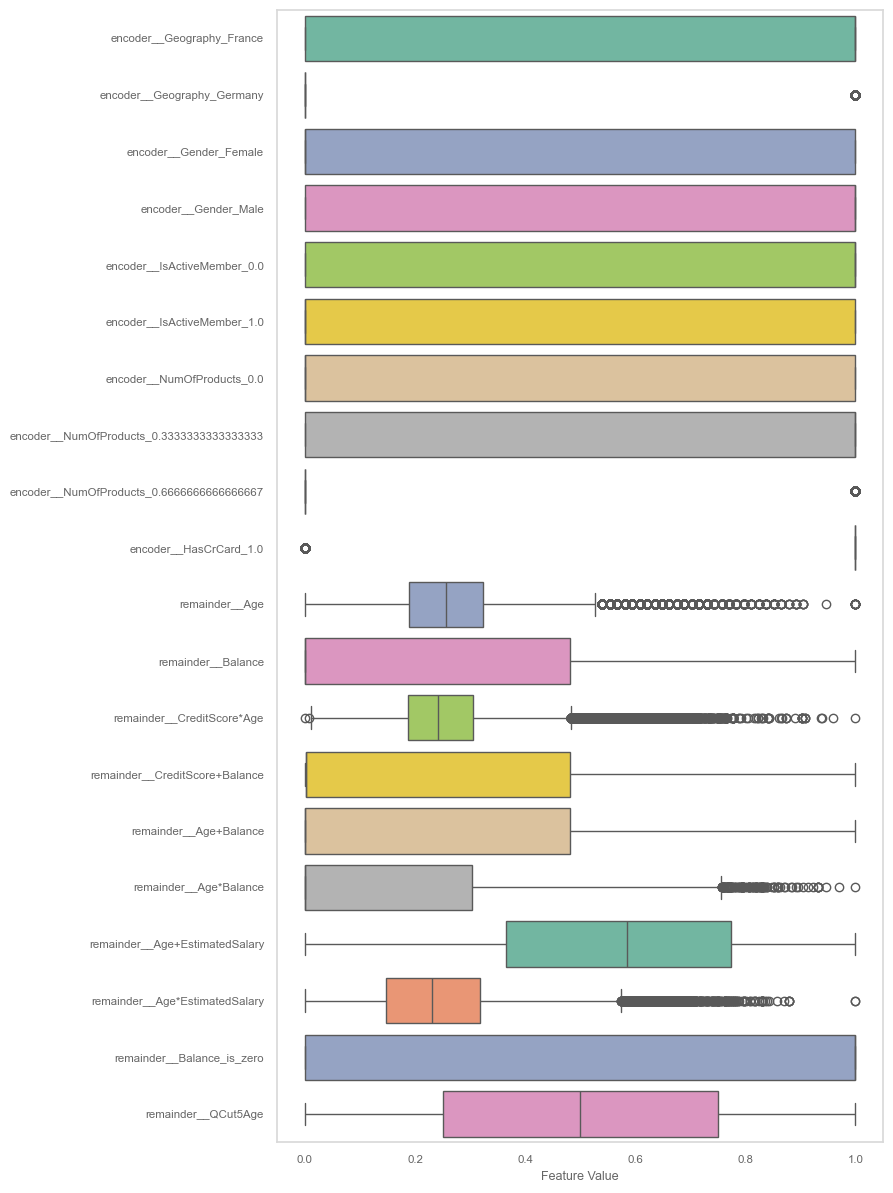

In [198]:
# Set graph style
sns.set(font_scale = 0.75)
sns.set_style({'axes.facecolor': '1.0', 'axes.edgecolor': '0.85', 'grid.color': '0.85',
               'grid.linestyle': '-', 'axes.labelcolor': '0.4', 'xtick.color': '0.4',
               'ytick.color': '0.4', 'axes.grid': False})

# Create box plots based on feature type

# Set the figure size
f, ax = plt.subplots(figsize=(9, 12))
sns.boxplot(data=train_df_sel, orient="h", palette="Set2")

# Set axis label
plt.xlabel('Feature Value')

# Tight layout
f.tight_layout()

# Save figure
f.savefig(f'Box Plots.png', dpi = 1080)

## 8. Model setup with pre-defined params

In [45]:
best_params_xgb = {'learning_rate': 0.09701089516649843, 
                   'max_depth': 5, 
                   'subsample': 0.8313883081132282}

best_params_lgbm = {'learning_rate': 0.09662854057910783, 
                    'max_depth': 5, 
                    'subsample': 0.958627306360428}

best_params_hist = {'learning_rate': 0.0713352287172605, 
                    'max_iter': 603, 
                    'max_leaf_nodes': 36}

xgboost_model = XGBClassifier(**best_params_xgb)
lgbm_model = LGBMClassifier(**best_params_lgbm, silent=True)
hist_model = HistGradientBoostingClassifier(**best_params_hist)

## 9. Pipeline setup

In [125]:
pipeline_baseline = Pipeline([
    ('encoder', encoding),
    ])

pipeline_baseline_binning = Pipeline([
    ('age_binning', age_binner),
    ('encoder', encoding),
    ])

pipeline_baseline_binning_sel = Pipeline([
    ('age_binning', age_binner),
    ('encoder', encoding),
    ('skb', feature_selector)
    ])

pipeline_baseline_binning_sel_arth = Pipeline([
    ('arithmetic_combiner', arithmetic_combiner),
    ('age_binning', age_binner),
    ('encoder', encoding),
    ('skb', feature_selector)
    ])

pipeline_baseline_plus = Pipeline([
    ('balance_zero_transformer', balance_zero_transformer),
    ('age_binning', age_binner),
    ('encoder', encoding),
    ])

pipeline_baseline_plus_sel = Pipeline([
    ('agg_balance_sum', agg_balance_sum),
    ('balance_zero_transformer', balance_zero_transformer),
    ('age_binning', age_binner),
    ('encoder', encoding),
    ('skb', feature_selector)
    ])

pipeline_baseline_plus_sel_pca = Pipeline([
    ('agg_balance_sum', agg_balance_sum),
    ('balance_zero_transformer', balance_zero_transformer),
    ('age_binning', age_binner),
    ('balance_binner', balance_binner),
    ('salary_binner', salary_binner),
    ('credit_score_binner', credit_score_binner),
    ('scaler', scaler),
    ('pca_cluster', pca_clustering_transformer),
    ('encoder', encoding),
    ('skb', feature_selector)
    ])

pipeline_all = Pipeline([
    ('arithmetic_combiner', arithmetic_combiner),
    ('agg_balance_sum', agg_balance_sum),
    ('balance_zero_transformer', balance_zero_transformer),
    ('age_binning', age_binner),
    ('balance_binner', balance_binner),
    ('salary_binner', salary_binner),
    ('credit_score_binner', credit_score_binner),
    ('scaler', scaler),
    ('pca_cluster', pca_clustering_transformer),
    ('encoder', encoding),
    ('skb', feature_selector)
    ])


selected_pipeline = pipeline_baseline_plus_sel_pca
selected_pipeline

Pipeline(steps=[('agg_balance_sum',
                 GroupByMergeTransformer(agg_col='Balance', agg_func='sum',
                                         group_col='CustomerId')),
                ('balance_zero_transformer', ZeroTransformer(column='Balance')),
                ('age_binning', Binning(col='Age', n_bins=5)),
                ('balance_binner', Binning(col='Balance', n_bins=5)),
                ('salary_binner', Binning(col='EstimatedSalary', n_bins=5)),
                ('credit_score_bi...
                 PCAClusteringTransformer(columns=['CustomerId',
                                                   'EstimatedSalary',
                                                   'Balance'],
                                          n_clusters=3, n_components=2)),
                ('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Geography', 'Gender',
                                                   'IsActiveMember', 'Tenure',
                                                   'NumOfProducts',
                                                   'HasCrCard'])])),
                ('skb', CustomFeatureSelector())])

In [124]:
xgboost_pipeline = make_pipeline(selected_pipeline, xgboost_model)

lgbm_pipeline = make_pipeline(selected_pipeline, lgbm_model)

hist_pipeline = make_pipeline(selected_pipeline, hist_model)

In [127]:
def log_results(pipeline, params, cv, model):
    steps = [step[0] for step in pipeline.named_steps['pipeline'].steps]
    steps = ', '.join(steps)
    log_df = pd.DataFrame()
    log_df['Time'] = [datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')]
    log_df['Pipeline'] = [steps]
    log_df['Params'] = [params]
    log_df['ROC AUC'] = [cv]
    log_df['Model'] = [model]

    if os.path.exists('log.csv'):
        log_df_ = pd.read_csv('log.csv')
        log_df = pd.concat([log_df_, log_df])
        log_df.to_csv('log.csv', index=False)
    else:
        log_df.to_csv('log.csv', index=False)

## 10. Training

### 10.1 Hyperparam tuning with Optuna

In [26]:
def instantiate_xgboost(trial : Trial) -> XGBClassifier:
  params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
  }
  return XGBClassifier(**params)

def instantiate_lgbm(trial : Trial) -> LGBMClassifier:
  params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
  }
  return LGBMClassifier(**params)

def instantiate_hist(trial: Trial) -> HistGradientBoostingClassifier:
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 20, 64),
    }
    return HistGradientBoostingClassifier(**params)

In [167]:
def objective(trial : Trial, pipeline, X, y ,algo):
    
    if algo == 'xgb':
        # XGBOOST
        # pipeline = make_pipeline(pipeline, instantiate_xgboost(trial))
        model = instantiate_xgboost(trial)
    elif algo == 'lgbm':
        # LGBM
        # pipeline = make_pipeline(pipeline, instantiate_lgbm(trial))
        model = instantiate_lgbm(trial)
    elif algo == 'hist':
        #pipeline = make_pipeline(pipeline, instantiate_hist(trial))
        model = instantiate_hist(trial)

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
    scores = cross_val_score(model, X, y, scoring=roc_auc_scorer, cv=skf)
  
    return np.min([np.mean(scores), np.median([scores])])

In [165]:
transformed_df = selected_pipeline.fit_transform(train_df[cat_cols+num_cols+['CustomerId']], train_df['Exited'])

study_xgb = create_study(study_name='optimization', direction='maximize', pruner=optuna.pruners.MedianPruner())

study_xgb.optimize(lambda trial: objective(trial, selected_pipeline, transformed_df, train_df['Exited'], 'xgb'), n_trials=50)

[I 2024-01-19 12:17:17,708] A new study created in memory with name: optimization
[I 2024-01-19 12:17:22,493] Trial 0 finished with value: 0.8867307430609439 and parameters: {'learning_rate': 0.02249220592298333, 'max_depth': 7, 'subsample': 0.15098759973628614}. Best is trial 0 with value: 0.8867307430609439.
[I 2024-01-19 12:17:25,343] Trial 1 finished with value: 0.8872596530226946 and parameters: {'learning_rate': 0.09564033884164612, 'max_depth': 3, 'subsample': 0.3452783628348863}. Best is trial 1 with value: 0.8872596530226946.
[I 2024-01-19 12:17:33,913] Trial 2 finished with value: 0.8859835429165122 and parameters: {'learning_rate': 0.0038739089768159442, 'max_depth': 10, 'subsample': 0.44316836888975736}. Best is trial 1 with value: 0.8872596530226946.
[I 2024-01-19 12:17:38,912] Trial 3 finished with value: 0.8868992652399591 and parameters: {'learning_rate': 0.09078349224922737, 'max_depth': 7, 'subsample': 0.33154770423996244}. Best is trial 1 with value: 0.88725965302269

In [168]:
transformed_df = selected_pipeline.fit_transform(train_df[cat_cols+num_cols+['CustomerId']], train_df['Exited'])

study_lgbm = create_study(study_name='optimization', direction='maximize', pruner=optuna.pruners.MedianPruner())

study_lgbm.optimize(lambda trial: objective(trial, selected_pipeline, transformed_df, train_df['Exited'], 'lgbm'), n_trials=50)

[I 2024-01-19 12:27:07,678] A new study created in memory with name: optimization


[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info

[I 2024-01-19 12:27:10,610] Trial 0 finished with value: 0.8804833444090252 and parameters: {'learning_rate': 0.026356118230218106, 'max_depth': 3, 'subsample': 0.7502281095698055}. Best is trial 0 with value: 0.8804833444090252.


[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info

[I 2024-01-19 12:27:12,888] Trial 1 finished with value: 0.8844945169167602 and parameters: {'learning_rate': 0.09826028450040855, 'max_depth': 2, 'subsample': 0.8574363719186133}. Best is trial 1 with value: 0.8844945169167602.


[LightGBM] [Info] Number of positive: 33263, number of negative: 124266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157529, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211155 -> initscore=-1.317979
[LightGBM] [Info] Start training from score -1.317979
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002544 seconds.
You c

[I 2024-01-19 12:27:18,159] Trial 2 finished with value: 0.8861733271449774 and parameters: {'learning_rate': 0.030576893930080968, 'max_depth': 5, 'subsample': 0.8487646432066259}. Best is trial 2 with value: 0.8861733271449774.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-01-19 12:27:24,322] Trial 3 finished with value: 0.8766606927291485 and parameters: {'learning_rate': 0.0011457249880577809, 'max_depth': 8, 'subsample': 0.4187415904654791}. Best is trial 2 with value: 0.8861733271449774.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-01-19 12:27:30,179] Trial 4 finished with value: 0.8880598310876398 and parameters: {'learning_rate': 0.07592469055263323, 'max_depth': 7, 'subsample': 0.8397837681124137}. Best is trial 4 with value: 0.8880598310876398.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-01-19 12:27:36,392] Trial 5 finished with value: 0.8827961099949052 and parameters: {'learning_rate': 0.010104270877896742, 'max_depth': 8, 'subsample': 0.7142345337435074}. Best is trial 4 with value: 0.8880598310876398.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [I

[I 2024-01-19 12:27:39,378] Trial 6 finished with value: 0.858637065908213 and parameters: {'learning_rate': 0.004528620707305807, 'max_depth': 3, 'subsample': 0.4538532734972917}. Best is trial 4 with value: 0.8880598310876398.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-01-19 12:27:45,674] Trial 7 finished with value: 0.8832261485527017 and parameters: {'learning_rate': 0.011271686306678434, 'max_depth': 9, 'subsample': 0.43116724759557656}. Best is trial 4 with value: 0.8880598310876398.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-01-19 12:27:51,615] Trial 8 finished with value: 0.8784662050571472 and parameters: {'learning_rate': 0.0030021381215078902, 'max_depth': 7, 'subsample': 0.270692302423292}. Best is trial 4 with value: 0.8880598310876398.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-01-19 12:27:57,825] Trial 9 finished with value: 0.8828354592139458 and parameters: {'learning_rate': 0.010205131348560527, 'max_depth': 8, 'subsample': 0.11878141429782471}. Best is trial 4 with value: 0.8880598310876398.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] No further splits with positiv

[I 2024-01-19 12:28:03,067] Trial 10 finished with value: 0.8878868539570377 and parameters: {'learning_rate': 0.06753097753347075, 'max_depth': 5, 'subsample': 0.9839870191508358}. Best is trial 4 with value: 0.8880598310876398.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [I

[I 2024-01-19 12:28:08,133] Trial 11 finished with value: 0.8881448135107699 and parameters: {'learning_rate': 0.0934034909014505, 'max_depth': 5, 'subsample': 0.9989119233571314}. Best is trial 11 with value: 0.8881448135107699.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.

[I 2024-01-19 12:28:13,938] Trial 12 finished with value: 0.8870827995397971 and parameters: {'learning_rate': 0.03772382859497368, 'max_depth': 6, 'subsample': 0.9892261279216475}. Best is trial 11 with value: 0.8881448135107699.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-01-19 12:28:20,229] Trial 13 finished with value: 0.887709952621252 and parameters: {'learning_rate': 0.05131431434597796, 'max_depth': 10, 'subsample': 0.601514288022478}. Best is trial 11 with value: 0.8881448135107699.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] No further splits with positiv

[I 2024-01-19 12:28:25,372] Trial 14 finished with value: 0.8881148141189873 and parameters: {'learning_rate': 0.09245868751746433, 'max_depth': 5, 'subsample': 0.8695953575193089}. Best is trial 11 with value: 0.8881448135107699.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002709 seconds.
You can set `force_row_wise=true` to remove the overhead.
An

[I 2024-01-19 12:28:29,183] Trial 15 finished with value: 0.8816878357000668 and parameters: {'learning_rate': 0.020386101545222284, 'max_depth': 4, 'subsample': 0.6548302106861716}. Best is trial 11 with value: 0.8881448135107699.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-01-19 12:28:34,506] Trial 16 finished with value: 0.8837592740473184 and parameters: {'learning_rate': 0.017958066737057153, 'max_depth': 5, 'subsample': 0.995428366946011}. Best is trial 11 with value: 0.8881448135107699.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-01-19 12:28:40,440] Trial 17 finished with value: 0.8875484288976387 and parameters: {'learning_rate': 0.048015728974812835, 'max_depth': 6, 'subsample': 0.8831180950850899}. Best is trial 11 with value: 0.8881448135107699.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [I

[I 2024-01-19 12:28:44,312] Trial 18 finished with value: 0.8699695865749787 and parameters: {'learning_rate': 0.004978527012730039, 'max_depth': 4, 'subsample': 0.7726892474227267}. Best is trial 11 with value: 0.8881448135107699.


[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2024-01-19 12:28:48,032] Trial 19 finished with value: 0.8878403275220338 and parameters: {'learning_rate': 0.08347313841481337, 'max_depth': 4, 'subsample': 0.5629055908166329}. Best is trial 11 with value: 0.8881448135107699.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, num

[I 2024-01-19 12:28:50,287] Trial 20 finished with value: 0.8809002805909584 and parameters: {'learning_rate': 0.05013522406857598, 'max_depth': 2, 'subsample': 0.9048828097608785}. Best is trial 11 with value: 0.8881448135107699.


[LightGBM] [Info] Number of positive: 33263, number of negative: 124266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157529, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211155 -> initscore=-1.317979
[LightGBM] [Info] Start training from score -1.317979
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003475 seconds.
You c

[I 2024-01-19 12:28:56,026] Trial 21 finished with value: 0.8881856702213515 and parameters: {'learning_rate': 0.09410342048861675, 'max_depth': 7, 'subsample': 0.776298242458977}. Best is trial 21 with value: 0.8881856702213515.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-01-19 12:29:01,575] Trial 22 finished with value: 0.8881944173328509 and parameters: {'learning_rate': 0.09543471120385692, 'max_depth': 6, 'subsample': 0.683329125602485}. Best is trial 22 with value: 0.8881944173328509.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start traini

[I 2024-01-19 12:29:07,872] Trial 23 finished with value: 0.8878862920763672 and parameters: {'learning_rate': 0.05735330699627872, 'max_depth': 7, 'subsample': 0.6946438218122108}. Best is trial 22 with value: 0.8881944173328509.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-01-19 12:29:13,718] Trial 24 finished with value: 0.8869028383611701 and parameters: {'learning_rate': 0.03533042378341124, 'max_depth': 6, 'subsample': 0.6314823043236151}. Best is trial 22 with value: 0.8881944173328509.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-01-19 12:29:19,829] Trial 25 finished with value: 0.8849455241331032 and parameters: {'learning_rate': 0.01836588218802208, 'max_depth': 7, 'subsample': 0.5161414134387914}. Best is trial 22 with value: 0.8881944173328509.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-01-19 12:29:25,994] Trial 26 finished with value: 0.888039589671347 and parameters: {'learning_rate': 0.06946838345321721, 'max_depth': 9, 'subsample': 0.7760144475279331}. Best is trial 22 with value: 0.8881944173328509.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-01-19 12:29:31,571] Trial 27 finished with value: 0.8882244948459613 and parameters: {'learning_rate': 0.09855830100892018, 'max_depth': 6, 'subsample': 0.9229850180229179}. Best is trial 27 with value: 0.8882244948459613.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-01-19 12:29:37,411] Trial 28 finished with value: 0.8872184238224087 and parameters: {'learning_rate': 0.04048643429633803, 'max_depth': 6, 'subsample': 0.7891771071431507}. Best is trial 27 with value: 0.8882244948459613.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-01-19 12:29:43,268] Trial 29 finished with value: 0.885690131768871 and parameters: {'learning_rate': 0.024751734826031085, 'max_depth': 6, 'subsample': 0.7258389774056024}. Best is trial 27 with value: 0.8882244948459613.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-01-19 12:29:49,401] Trial 30 finished with value: 0.8879307026311496 and parameters: {'learning_rate': 0.06458851694982108, 'max_depth': 8, 'subsample': 0.9261431741029262}. Best is trial 27 with value: 0.8882244948459613.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] No further splits with positiv

[I 2024-01-19 12:29:54,527] Trial 31 finished with value: 0.8881748275985312 and parameters: {'learning_rate': 0.09509212243535568, 'max_depth': 5, 'subsample': 0.9375148002394308}. Best is trial 27 with value: 0.8882244948459613.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [I

[I 2024-01-19 12:30:00,254] Trial 32 finished with value: 0.888233346405707 and parameters: {'learning_rate': 0.0990995284708263, 'max_depth': 7, 'subsample': 0.8061419916322969}. Best is trial 32 with value: 0.888233346405707.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-01-19 12:30:06,184] Trial 33 finished with value: 0.8880031344696466 and parameters: {'learning_rate': 0.06582058652220268, 'max_depth': 7, 'subsample': 0.8306934176976041}. Best is trial 32 with value: 0.888233346405707.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-01-19 12:30:12,275] Trial 34 finished with value: 0.8863328019792652 and parameters: {'learning_rate': 0.027813773053647205, 'max_depth': 7, 'subsample': 0.6731343280990117}. Best is trial 32 with value: 0.888233346405707.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-01-19 12:30:18,535] Trial 35 finished with value: 0.8874950280087812 and parameters: {'learning_rate': 0.04495931758855085, 'max_depth': 9, 'subsample': 0.7938144071575725}. Best is trial 32 with value: 0.888233346405707.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-01-19 12:30:24,409] Trial 36 finished with value: 0.8881231110282964 and parameters: {'learning_rate': 0.09789050246262032, 'max_depth': 8, 'subsample': 0.7369741703875258}. Best is trial 32 with value: 0.888233346405707.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-01-19 12:30:30,041] Trial 37 finished with value: 0.87630015434639 and parameters: {'learning_rate': 0.0018203019409842147, 'max_depth': 6, 'subsample': 0.8170067206620161}. Best is trial 32 with value: 0.888233346405707.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-01-19 12:30:36,039] Trial 38 finished with value: 0.8838679668306018 and parameters: {'learning_rate': 0.013337806419245608, 'max_depth': 7, 'subsample': 0.5086889764535852}. Best is trial 32 with value: 0.888233346405707.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-01-19 12:30:41,715] Trial 39 finished with value: 0.8803235053213223 and parameters: {'learning_rate': 0.006359204072407973, 'max_depth': 6, 'subsample': 0.33643379960260905}. Best is trial 32 with value: 0.888233346405707.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-01-19 12:30:47,727] Trial 40 finished with value: 0.8881347745172399 and parameters: {'learning_rate': 0.07646058589025086, 'max_depth': 8, 'subsample': 0.8514880206021818}. Best is trial 32 with value: 0.888233346405707.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] No further splits with positiv

[I 2024-01-19 12:30:52,812] Trial 41 finished with value: 0.8881214239641319 and parameters: {'learning_rate': 0.08336077934876698, 'max_depth': 5, 'subsample': 0.9313962577724455}. Best is trial 32 with value: 0.888233346405707.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [In

[I 2024-01-19 12:30:56,475] Trial 42 finished with value: 0.8878883490827201 and parameters: {'learning_rate': 0.09540519784303686, 'max_depth': 4, 'subsample': 0.9303703697694734}. Best is trial 32 with value: 0.888233346405707.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad sinc

[I 2024-01-19 12:31:01,650] Trial 43 finished with value: 0.887758632117578 and parameters: {'learning_rate': 0.058407349833684195, 'max_depth': 5, 'subsample': 0.7417865590665834}. Best is trial 32 with value: 0.888233346405707.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad sinc

[I 2024-01-19 12:31:07,497] Trial 44 finished with value: 0.8880985100788408 and parameters: {'learning_rate': 0.07798561313892795, 'max_depth': 7, 'subsample': 0.9472097692914305}. Best is trial 32 with value: 0.888233346405707.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [I

[I 2024-01-19 12:31:10,271] Trial 45 finished with value: 0.8833485428136238 and parameters: {'learning_rate': 0.03545674209297395, 'max_depth': 3, 'subsample': 0.8780912843530264}. Best is trial 32 with value: 0.888233346405707.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-01-19 12:31:15,954] Trial 46 finished with value: 0.8878808731807618 and parameters: {'learning_rate': 0.061274348667673145, 'max_depth': 6, 'subsample': 0.8320803338926125}. Best is trial 32 with value: 0.888233346405707.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] No further splits with positiv

[I 2024-01-19 12:31:20,990] Trial 47 finished with value: 0.8882581635967355 and parameters: {'learning_rate': 0.09662854057910783, 'max_depth': 5, 'subsample': 0.958627306360428}. Best is trial 47 with value: 0.8882581635967355.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explici

[I 2024-01-19 12:31:26,916] Trial 48 finished with value: 0.8880733871100276 and parameters: {'learning_rate': 0.07301658396675513, 'max_depth': 7, 'subsample': 0.11786780525610735}. Best is trial 47 with value: 0.8882581635967355.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 33263, number of negative: 124265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 157528, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317971
[LightGBM] [Info] Start training from score -1.317971
[LightGBM] [Warning] Accuracy may be bad since you 

[I 2024-01-19 12:31:33,180] Trial 49 finished with value: 0.880539638984178 and parameters: {'learning_rate': 0.007514927487233994, 'max_depth': 8, 'subsample': 0.59226784250038}. Best is trial 47 with value: 0.8882581635967355.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [169]:
transformed_df = selected_pipeline.fit_transform(train_df[cat_cols+num_cols+['CustomerId']], train_df['Exited'])

study_hist = create_study(study_name='optimization', direction='maximize', pruner=optuna.pruners.MedianPruner())

study_hist.optimize(lambda trial: objective(trial, selected_pipeline, transformed_df, train_df['Exited'], 'hist'), n_trials=50)

[I 2024-01-19 12:43:20,126] A new study created in memory with name: optimization
[I 2024-01-19 12:44:04,105] Trial 0 finished with value: 0.8877351009382023 and parameters: {'learning_rate': 0.07474837880377516, 'max_iter': 733, 'max_leaf_nodes': 59}. Best is trial 0 with value: 0.8877351009382023.
[I 2024-01-19 12:44:24,618] Trial 1 finished with value: 0.8877702119568825 and parameters: {'learning_rate': 0.13508140895103604, 'max_iter': 160, 'max_leaf_nodes': 44}. Best is trial 1 with value: 0.8877702119568825.
[I 2024-01-19 12:44:39,199] Trial 2 finished with value: 0.887489915185088 and parameters: {'learning_rate': 0.1833038442707651, 'max_iter': 704, 'max_leaf_nodes': 39}. Best is trial 1 with value: 0.8877702119568825.
[I 2024-01-19 12:44:48,678] Trial 3 finished with value: 0.8871995148365922 and parameters: {'learning_rate': 0.2944309953612552, 'max_iter': 530, 'max_leaf_nodes': 33}. Best is trial 1 with value: 0.8877702119568825.
[I 2024-01-19 12:45:02,533] Trial 4 finished 

KeyboardInterrupt: 

In [201]:
# XGBOOST
best_params = study_xgb.best_params
xgboost_model = XGBClassifier(**best_params, silent=True)
xgboost_pipeline = make_pipeline(selected_pipeline, xgboost_model)
average_cv_result = study_xgb.best_trial.values[0]
log_results(xgboost_pipeline, best_params, average_cv_result, 'xgboost')

# LGBM
best_params = study_lgbm.best_params
lgbm_model = LGBMClassifier(**best_params, silent=True)
lgbm_pipeline = make_pipeline(selected_pipeline, lgbm_model)
average_cv_result = study_lgbm.best_trial.values[0]
log_results(lgbm_pipeline, best_params, average_cv_result, 'lgbm')

# HIST
#best_params = study_hist.best_params
best_params = {'learning_rate': 0.0713352287172605, 'max_iter': 603, 'max_leaf_nodes': 36}
hist_model = HistGradientBoostingClassifier(**best_params)
hist_pipeline = make_pipeline(selected_pipeline, hist_model)
average_cv_result = study_hist.best_trial.values[0]
log_results(hist_pipeline, best_params, average_cv_result, 'hist')

### 10.2 No Hyperparam tuning

In [140]:
def crossval(pipeline, params):
    X = train_df[cat_cols+num_cols+['CustomerId']]
    y = train_df['Exited']

    # number of folds
    n_splits = 10

    #  StratifiedKFold
    stratkf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    #  cross-validation results
    cv_results = []

    # stratified k-fold cross-validation
    for fold, (train_idx, val_idx) in enumerate(stratkf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        pipeline.fit(X_train, y_train)

        # predictions on the validation set
        y_val_pred_prob = pipeline.predict_proba(X_val)[:,1]
            
        # Evaluating the model
        roc_auc = roc_auc_score(y_val, y_val_pred_prob)
        print(f'Fold {fold + 1}, AUC Score on Validation Set: {roc_auc}')
        print('-'*70)

        # results
        cv_results.append(roc_auc)

    # average cross-validation result
    average_cv_result = sum(cv_results) / n_splits
    print(f'\nAverage AUC-score across {n_splits} folds: {average_cv_result}')
    log_results(pipeline, params, average_cv_result, 'catboost')

In [142]:
crossval(xgboost_pipeline, best_params_xgb)
crossval(lgbm_pipeline, best_params_lgbm)
crossval(hist_pipeline, best_params_hist)

Fold 1, AUC Score on Validation Set: 0.8920078927936466
----------------------------------------------------------------------
Fold 2, AUC Score on Validation Set: 0.8876260555504496
----------------------------------------------------------------------
Fold 3, AUC Score on Validation Set: 0.8903596323457175
----------------------------------------------------------------------
Fold 4, AUC Score on Validation Set: 0.8873351190891505
----------------------------------------------------------------------
Fold 5, AUC Score on Validation Set: 0.8856456093236112
----------------------------------------------------------------------
Fold 6, AUC Score on Validation Set: 0.8944210832969512
----------------------------------------------------------------------
Fold 7, AUC Score on Validation Set: 0.88722630547084
----------------------------------------------------------------------
Fold 8, AUC Score on Validation Set: 0.8930906269899563
---------------------------------------------------------

## 11. Result Evaluation

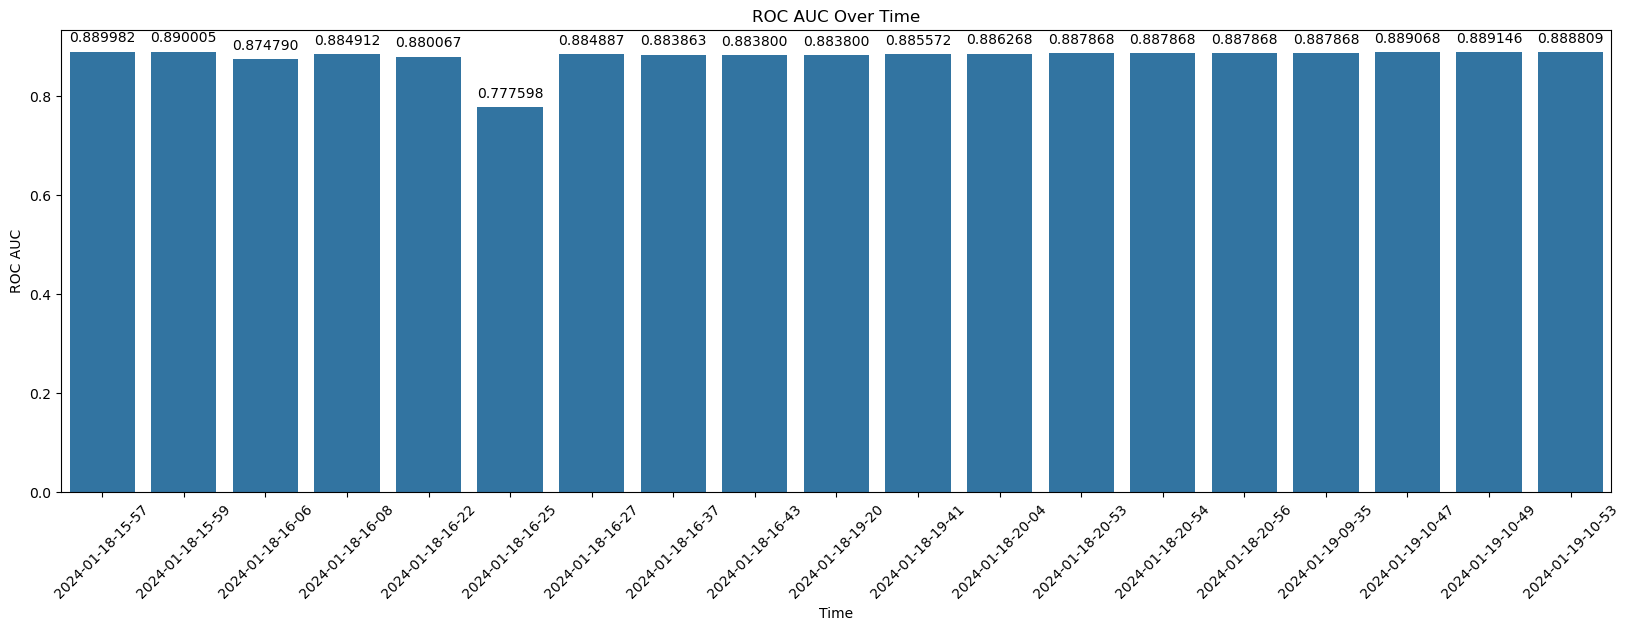

----------------------------------------------------------------------
encoder
catboost
{'iterations': 1000, 'learning_rate': 0.0334, 'depth': 6, 'subsample': 0.49, 'random_strength': 0.00527, 'l2_leaf_reg': 19.32, 'model_size_reg': 12.051}
0.8899819036038054
----------------------------------------------------------------------
age_binning, encoder
catboost
{'iterations': 1000, 'learning_rate': 0.0334, 'depth': 6, 'subsample': 0.49, 'random_strength': 0.00527, 'l2_leaf_reg': 19.32, 'model_size_reg': 12.051}
0.8900045215754551
----------------------------------------------------------------------
age_binning, encoder, scaler, skb
catboost
{'iterations': 1000, 'learning_rate': 0.0334, 'depth': 6, 'subsample': 0.49, 'random_strength': 0.00527, 'l2_leaf_reg': 19.32, 'model_size_reg': 12.051}
0.8747904837669018
----------------------------------------------------------------------
age_binning, encoder, skb
 catboost
{'iterations': 1000, 'learning_rate': 0.0334, 'depth': 6, 'subsample': 0.4

In [143]:
df_log = pd.read_csv('log.csv')
plt.figure(figsize=(20, 6))
ax = sns.barplot(data=df_log, x='Time', y='ROC AUC')
plt.xticks(rotation=45)
plt.title('ROC AUC Over Time')
plt.xlabel('Time')
plt.ylabel('ROC AUC')

# Adding the text on the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.6f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.show()

for param, pipeline, model, score  in zip(df_log['Params'], df_log['Pipeline'], df_log['Model'], df_log['ROC AUC']):
    print('-'*70)
    print(pipeline)
    print(model)
    print(param)
    print(score)

## 12. Ensemble

### 12.1 Hyperparameter tuning of weights for ensemble

In [144]:
def objective(trial: Trial, xgboost_pipeline, lgbm_pipeline, hist_pipeline):
    X = train_df[cat_cols+num_cols+['CustomerId']]
    y = train_df['Exited']

    # Suggest weights for the ensemble components
    weight_xgb = trial.suggest_float('xgb_weight', 0.1, 1)
    weight_lgbm = trial.suggest_float('lgbm_weight', 0.1, 1)
    weight_hist = trial.suggest_float('hist_weight', 0.1, 1)

    # Create the ensemble model with the suggested weights
    ensemble_model = VotingClassifier(
        estimators=[
            ('xgb', xgboost_pipeline),
            ('lgbm', lgbm_pipeline),
            ('hist', hist_pipeline),
        ],
        voting='soft',
        weights=[weight_xgb, weight_lgbm, weight_hist]
    )

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
    scores = cross_val_score(ensemble_model, X, y, scoring=roc_auc_scorer, cv=skf)

    # Return the mean of the ROC AUC scores
    return np.mean(scores)

In [145]:
study_ensemble = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study_ensemble.optimize(lambda trial: objective(trial, xgboost_pipeline, lgbm_pipeline, hist_pipeline), n_trials=10)

[I 2024-01-19 10:54:18,067] A new study created in memory with name: no-name-5dc3deb9-a29b-46c6-8b65-123442015d64
[W 2024-01-19 10:54:25,317] Trial 0 failed with parameters: {'xgb_weight': 0.23243111052010815, 'lgbm_weight': 0.4077193012851566, 'hist_weight': 0.9818832689049048} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/krystianpietrzak/Documents/ML/Kaggle/Kaggle-S4E1/.conda/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/x1/2j32gjvd4v16s6kf306sfdcw0000gn/T/ipykernel_55432/1934351666.py", line 2, in <lambda>
    study_ensemble.optimize(lambda trial: objective(trial, xgboost_pipeline, lgbm_pipeline, hist_pipeline), n_trials=10)
                                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/x1/2j32gjvd4v16s6kf306sfdcw0000gn/T/ipykernel_55432/77

KeyboardInterrupt: 

In [202]:
best_params_ensemble = {'xgb_weight': 0.9476128707220737, 'lgbm_weight': 0.5626673694518467, 'hist_weight': 0.23987315205853274}
ensemble_model = VotingClassifier(estimators=[
                                                ('xgb', xgboost_pipeline),
                                                ('lgbm', lgbm_pipeline),
                                                ('hist', hist_pipeline),
                                             ], voting='soft', weights = [best_params_ensemble['xgb_weight'], best_params_ensemble['lgbm_weight'], best_params_ensemble['hist_weight']]) 

## Pseudo Labels

In [664]:
if CFG.use_pseudo:
    ensemble_model.fit(train_df[cat_cols + num_cols+['CustomerId']], train_df['Exited'])
    test_preds = ensemble_model.predict(test_df[cat_cols + num_cols+['CustomerId']])

    test_df['predictions'] = test_preds
    test_df.head()

    cutoff = 0.95 # Probability CutOff...
    pseudo_set_1 = test_df[test_df['predictions'] > cutoff]
    pseudo_set_1['Exited'] = 1
    pseudo_set_1.drop(columns=['predictions'], axis = 1, inplace=True)

    pseudo_set_2 = test_df[test_df['predictions'] < 1 - cutoff]
    pseudo_set_2['Exited'] = 0
    pseudo_set_2.drop(columns=['predictions'], axis = 1, inplace=True)

    pseudo_set = pd.concat([pseudo_set_1,pseudo_set_2])
    
    pseudo_train_df = pd.concat([train_df, pseudo_set])
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
    scores = cross_val_score(ensemble_model, pseudo_train_df[cat_cols + num_cols+['CustomerId']], pseudo_train_df['Exited'], scoring=roc_auc_scorer, cv=skf)
    print(f'ROC-AUC: {np.min([np.mean(scores), np.median([scores])])}')

    ensemble_model.fit(pseudo_train_df[cat_cols + num_cols+['CustomerId']], pseudo_train_df['Exited'])
    test_probabilities = ensemble_model.predict_proba(test_df[cat_cols + num_cols + ['CustomerId']])[:,1]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 36959, number of negative: 138073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1113
[LightGBM] [Info] Number of data points in the train set: 175032, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317973
[LightGBM] [Info] Start training from score -1.317973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

(110023, 13)

## SHAP

### XGBoost

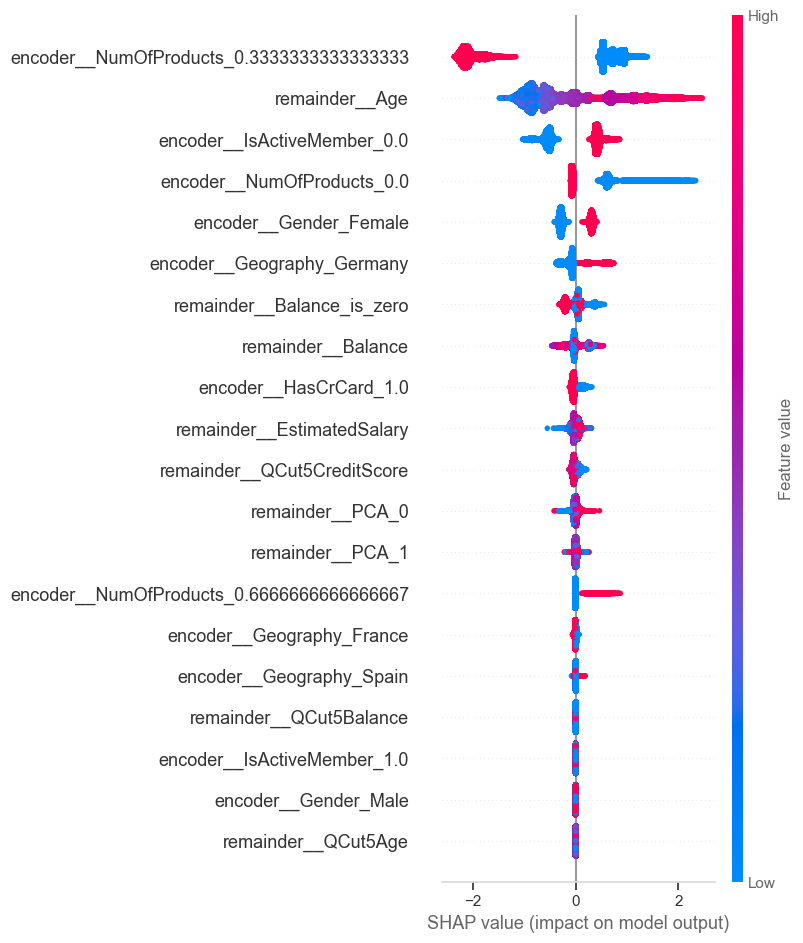

In [225]:
model = ensemble_model.named_estimators['xgb'][1]
train_df_transformed = selected_pipeline.fit_transform(train_df[cat_cols + num_cols + ['CustomerId']], train_df['Exited'])
test_df_transformed = selected_pipeline.transform(test_df[cat_cols + num_cols + ['CustomerId']])
model.fit(train_df_transformed, train_df['Exited'])
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(test_df_transformed)
shap.summary_plot(shap_values, test_df_transformed)

### LGBM

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 36959, number of negative: 138073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1129
[LightGBM] [Info] Number of data points in the train set: 175032, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317973
[LightGBM] [Info] Start training from score -1.317973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

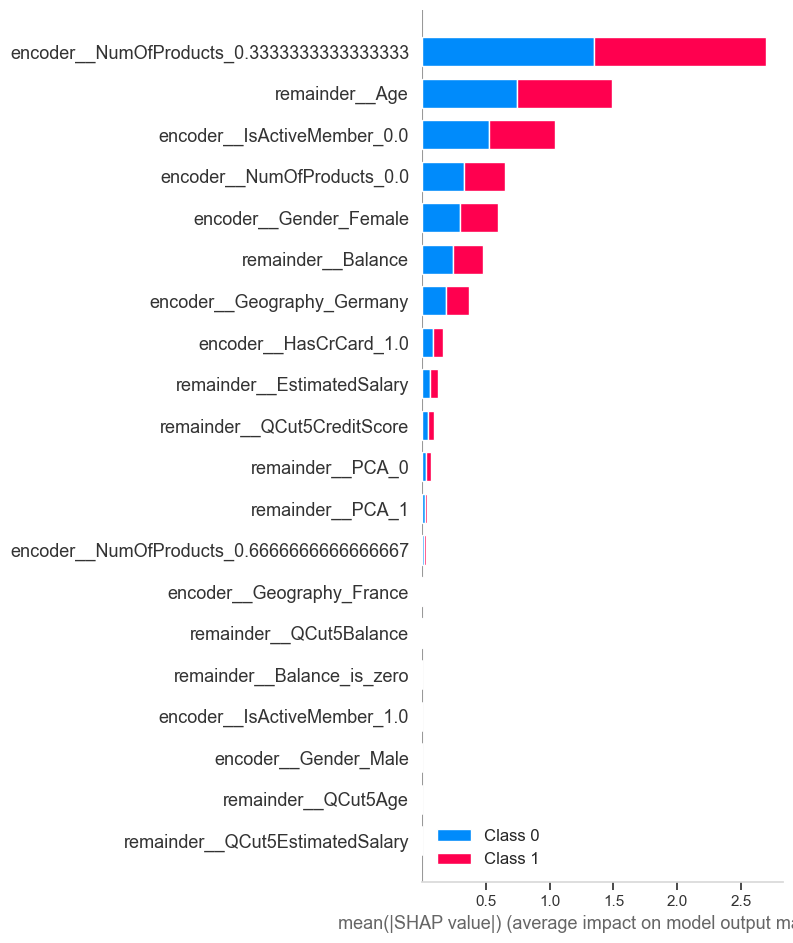

In [226]:
model = ensemble_model.named_estimators['lgbm'][1]
train_df_transformed = selected_pipeline.fit_transform(train_df[cat_cols + num_cols + ['CustomerId']], train_df['Exited'])
test_df_transformed = selected_pipeline.transform(test_df[cat_cols + num_cols + ['CustomerId']])
model.fit(train_df_transformed, train_df['Exited'])
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(test_df_transformed)
shap.summary_plot(shap_values, test_df_transformed)

### Hist

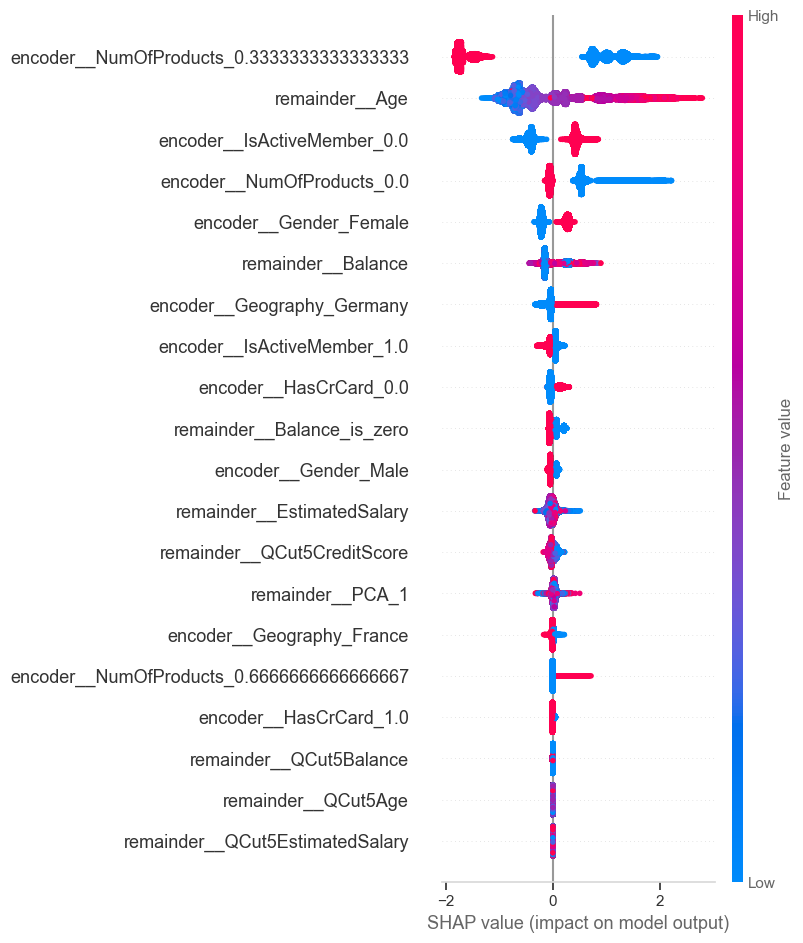

In [227]:
model = ensemble_model.named_estimators['hist'][1]
train_df_transformed = selected_pipeline.fit_transform(train_df[cat_cols + num_cols + ['CustomerId']], train_df['Exited'])
test_df_transformed = selected_pipeline.transform(test_df[cat_cols + num_cols + ['CustomerId']])
model.fit(train_df_transformed, train_df['Exited'])
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(test_df_transformed)
shap.summary_plot(shap_values, test_df_transformed)

## Submission

In [215]:
ensemble_model.fit(train_df[cat_cols + num_cols+['CustomerId']], train_df['Exited'])
test_probabilities = ensemble_model.predict_proba(test_df[cat_cols + num_cols+['CustomerId']])[:,1]

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 36959, number of negative: 138073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1129
[LightGBM] [Info] Number of data points in the train set: 175032, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211156 -> initscore=-1.317973
[LightGBM] [Info] Start training from score -1.317973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

In [174]:
sub = pd.DataFrame()
sub['id'] = test_df['id']
sub['Exited'] = test_probabilities
sub = sub.set_index('id')
sub.head()

,Exited
id,
165034,0.02
165035,0.83
165036,0.02
165037,0.24
165038,0.41


In [175]:
sub.to_csv('submission.csv')